## Overview

In this tutorial, we will build a simple aritificial neural network (ANN), also known as multilayer perceptron (MLP) or feedforward neural network (FNN). The learning outcomes are:
1. Understand how the model is formulated mathematically;
2. Understand what is meant by training the network;
3. Experiment with more complex architectures.

## Data

We generate data from a Gaussian process with a specified covariance matrix. The details of data generation do not matter as in reality, you never know the actual data generation machanism.

**The key** here is that we want to predict $y \in R^5$ given the previous values $x\in R^{25}$.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

sys.path.insert(1, '..')
os.chdir('..')

from data_formatters.weinstock2016 import *
from dataset import TSDataset
from conf import Conf

In [2]:
# loading the config file, setting the experiment name, and the seed for random pre-processing parts (like splitting)
cnf = Conf(conf_file_path='./conf/weinstock.yaml', seed=15, exp_name="Weinstock", log=False)

In [3]:
# call the data fromatter directly
data_formatter = WeinstockFormatter(cnf)

Dropped segments: 1012
Extracted segments: 1085


In [4]:
# we are going to pass our data formatter and the config file to the TSDataset class
train_dataset = TSDataset(cnf, data_formatter, split='train')
val_dataset = TSDataset(cnf, data_formatter, split='val')
test_dataset = TSDataset(cnf, data_formatter, split='test')

Getting valid sampling locations.
# available segments=252901
Extracting 5000 samples out of 252901
1000 of 5000 samples done...
2000 of 5000 samples done...
3000 of 5000 samples done...
4000 of 5000 samples done...
5000 of 5000 samples done...
Getting valid sampling locations.
# available segments=474
Extracting all available segments.
Getting valid sampling locations.
# available segments=44660
Extracting 5000 samples out of 44660
1000 of 5000 samples done...
2000 of 5000 samples done...
3000 of 5000 samples done...
4000 of 5000 samples done...
5000 of 5000 samples done...


[1.90e+03 1.00e+00 1.50e+01 0.00e+00 4.50e+01 2.06e+02]


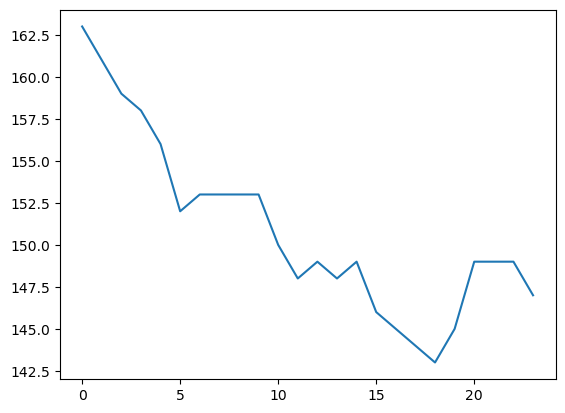

[1.9e+03 1.0e+00 2.0e+00 1.0e+01 1.5e+01 1.9e+02]


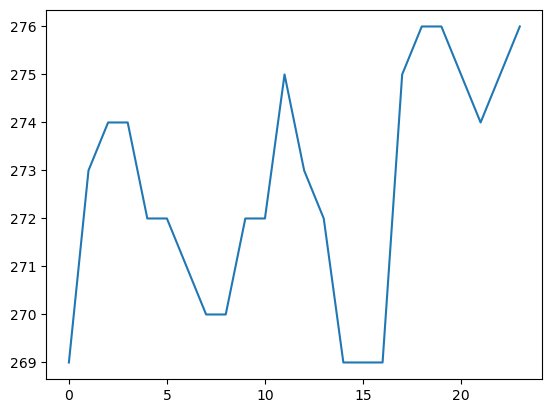

[1.9e+03 1.0e+00 3.0e+00 2.0e+00 2.5e+01 7.9e+01]


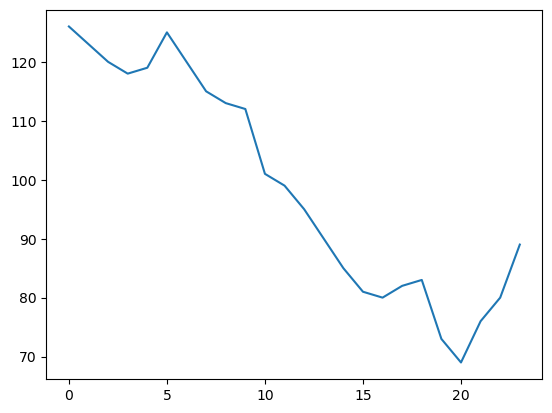

[1.90e+03 1.00e+00 3.00e+00 1.00e+00 0.00e+00 1.48e+02]


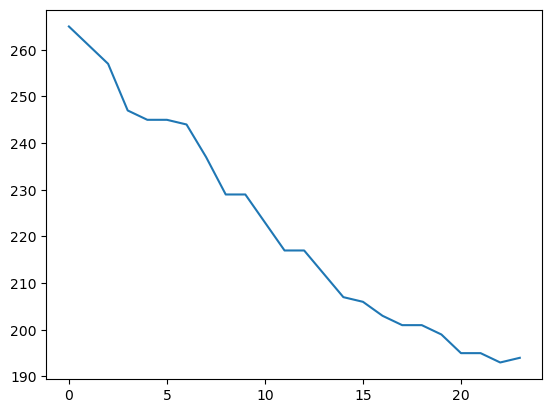

[1.90e+03 1.00e+00 1.00e+01 1.60e+01 2.00e+01 1.33e+02]


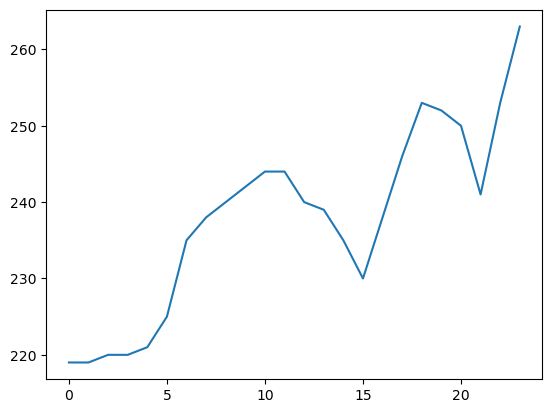

In [5]:
for i in range(5):
    # 192 x ['power_usage', 'hour', 'day_of_week', 'hours_from_start', 'categorical_id']
    x = test_dataset[i]['inputs']
    print(x[0, :])
    # 24 x ['power_usage']
    y = test_dataset[i]['outputs']

    # plt.plot(x[:, 5])
    plt.plot(y)
    plt.show()

In [6]:
# set up torch dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Linear regression

Suppose we want to model our data as a linear transformation, that is we aim to find $W \in R^{25\times 5}$ so that to minimize the squared error between the prediction and the truth. In summary, we formulate the problem as:
$$
W^* = \argmin_{W} || Y -  XW ||^2
$$

This model is an extension of the model many of us have covered in the introductory statisics courses to a multivariate case. **Recall** that for one-dimensional case (i.e. when $y \in R$) and under some distributional assumptions, this optimization problem has a closed form solution that is guaranteed to be the best (BLUE). When we move to more dimensions and start relaxing the assumptions, we no longer have the closed-form solution. Hence, we need to resort to the apprximate methods. Below, we program the model and see its performance.

In [7]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear_collapse = torch.nn.Linear(6, 1)
        self.linear = torch.nn.Linear(192, 24)
        
    def forward(self, x):
        y_pred = self.linear(torch.squeeze(self.linear_collapse(x)))
        return y_pred

In [18]:
# train model
best_loss = 1e1000
model = LinearModel()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.000000001)
for epoch in range(100):
    # for i, (inputs, labels) in enumerate(train_loader):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        # for i, (inputs, labels) in enumerate(val_loader):
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model_linear.pth')
# load best model
model.load_state_dict(torch.load('best_model_linear.pth'))

Epoch [1/100], Loss: 38114.3164
Epoch [1/100], Val Loss: 47288.7656
Epoch [2/100], Loss: 23456.6875
Epoch [2/100], Val Loss: 43405.4727
Epoch [3/100], Loss: 28133.9785
Epoch [3/100], Val Loss: 40157.8672
Epoch [4/100], Loss: 21554.5742
Epoch [4/100], Val Loss: 36700.9414
Epoch [5/100], Loss: 35236.3633
Epoch [5/100], Val Loss: 32798.0078
Epoch [6/100], Loss: 28309.7676
Epoch [6/100], Val Loss: 28566.4004
Epoch [7/100], Loss: 17560.1562
Epoch [7/100], Val Loss: 24325.7363
Epoch [8/100], Loss: 7732.0288
Epoch [8/100], Val Loss: 20444.9258
Epoch [9/100], Loss: 16854.4941
Epoch [9/100], Val Loss: 17194.1953
Epoch [10/100], Loss: 8880.4346
Epoch [10/100], Val Loss: 14683.8301
Epoch [11/100], Loss: 5708.6426
Epoch [11/100], Val Loss: 12861.9814
Epoch [12/100], Loss: 12558.7188
Epoch [12/100], Val Loss: 11589.8906
Epoch [13/100], Loss: 9032.5088
Epoch [13/100], Val Loss: 10719.4277
Epoch [14/100], Loss: 8016.9087
Epoch [14/100], Val Loss: 10152.9697
Epoch [15/100], Loss: 7096.0820
Epoch [15/1

<All keys matched successfully>

In [19]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 7900.7251


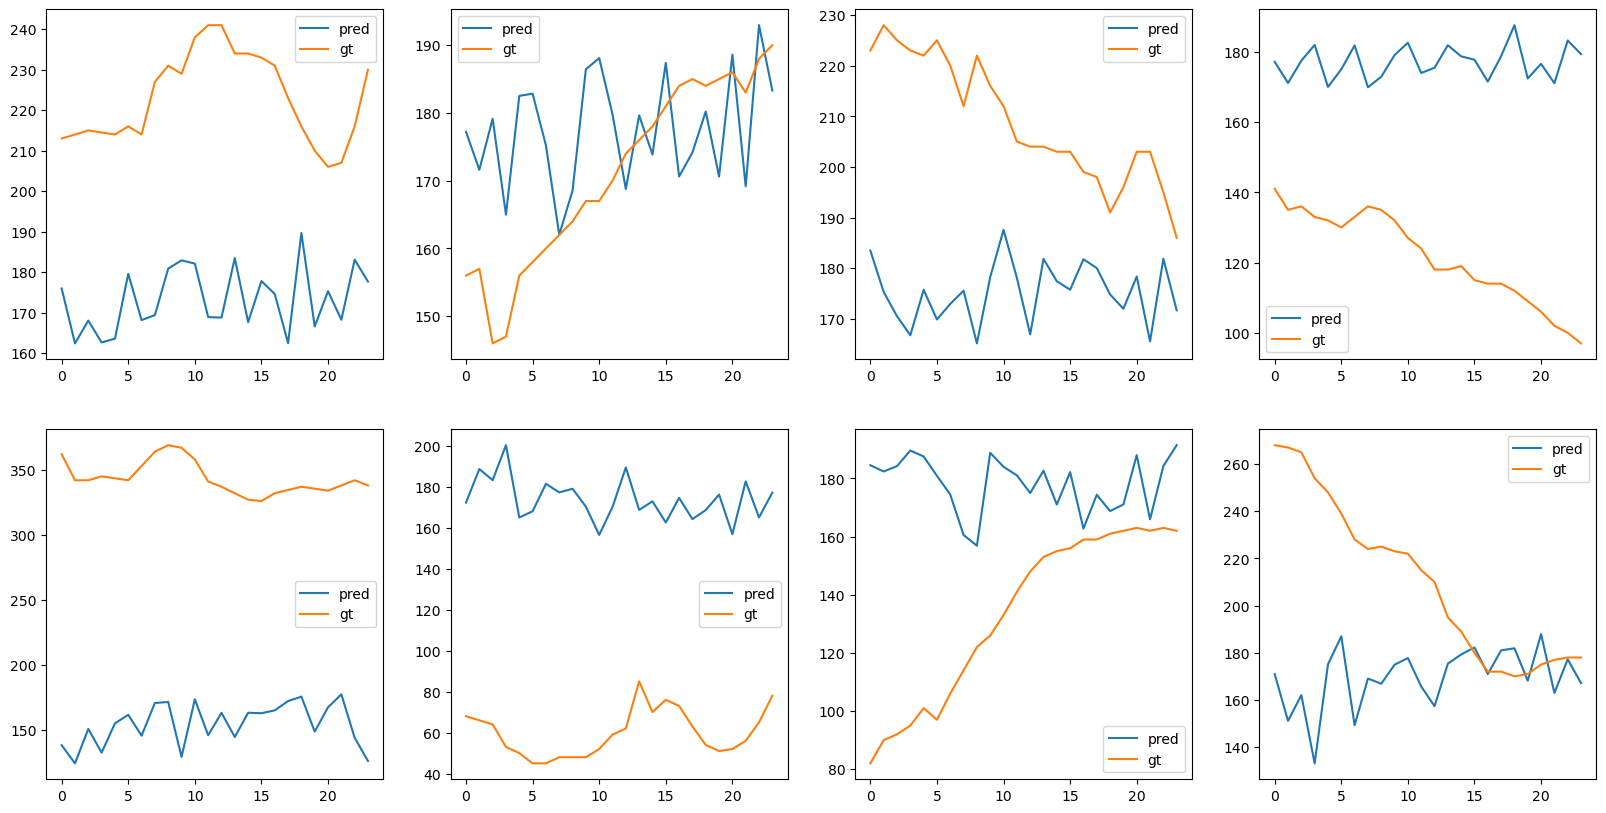

In [20]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
labels = d.get('outputs')
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()

## Can we do better?

In our case, there is little justification to move beyond the linear regression setting because of how the data is generated. Nevertheless, nobody is stopping us from trying. Let's now formulate our model as: $$\hat y  = (ReLU(XW^{(1)})) W^{(2)},$$
where $W^{(1)} \in R^{25 \times n_1}, W^{(2)} \in R^{n_1 \times 5}$ are learnable weight matrie and $n_1$ is a hyper-parameter we get to choose.

The main points we want to you to notice from this example are:
1. More complex models do not mean better performance;
2. Hyper-parameter tuning is tedious;
3. **Most importantly**, we can learn any differentiable architecture with the help of SGD.

In [11]:
# define model
class MLP(torch.nn.Module):
    def __init__(self, n1):
        super(MLP, self).__init__()
        self.linear_collapse = torch.nn.Linear(6, 1)
        self.linear = torch.nn.Linear(192, n1)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(n1, 24)
        
    def forward(self, x):
        y_pred = self.linear2(self.relu(self.linear(torch.squeeze(self.linear_collapse(x)))))
        return y_pred

In [15]:
# train model
best_loss = 1e10000
model = MLP(100)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.000000001)
for epoch in range(100):
    # for i, (inputs, labels) in enumerate(train_loader):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        # for i, (inputs, labels) in enumerate(val_loader):
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model_mlp.pth')
# load best model
model.load_state_dict(torch.load('best_model_mlp.pth'))

Epoch [1/100], Loss: 24557.2266
Epoch [1/100], Val Loss: 38949.7070
Epoch [2/100], Loss: 33362.1992
Epoch [2/100], Val Loss: 28801.5859
Epoch [3/100], Loss: 31948.6328
Epoch [3/100], Val Loss: 22482.1641
Epoch [4/100], Loss: 17400.3223
Epoch [4/100], Val Loss: 18287.3906
Epoch [5/100], Loss: 15841.0273
Epoch [5/100], Val Loss: 15448.6846
Epoch [6/100], Loss: 13917.1758
Epoch [6/100], Val Loss: 13440.3359
Epoch [7/100], Loss: 5502.8555
Epoch [7/100], Val Loss: 11998.6807
Epoch [8/100], Loss: 5679.2534
Epoch [8/100], Val Loss: 10963.5244
Epoch [9/100], Loss: 2811.7156
Epoch [9/100], Val Loss: 10212.1602
Epoch [10/100], Loss: 5649.5210
Epoch [10/100], Val Loss: 9664.1973
Epoch [11/100], Loss: 11187.2500
Epoch [11/100], Val Loss: 9260.0830
Epoch [12/100], Loss: 3411.1709
Epoch [12/100], Val Loss: 8981.1738
Epoch [13/100], Loss: 3056.6565
Epoch [13/100], Val Loss: 8776.2090
Epoch [14/100], Loss: 3439.3914
Epoch [14/100], Val Loss: 8612.6885
Epoch [15/100], Loss: 9101.8154
Epoch [15/100], Va

<All keys matched successfully>

In [16]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 6963.6543


In [22]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
labels = d.get('outputs')
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()